In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import basic package and Setting basic functions

In [45]:
import numpy as np
from core import stagger_FD_coeff as sfci
from core.utils import cholesky_solver
from neal import SimulatedAnnealingSampler
from dwave.system import DWaveSampler
from core.QUBO_solvers import IterSampleSolver
from collections import ChainMap
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import time
from functools import wraps
pi = np.pi

In [46]:
def solve_coeff_Taylor():
    tra_a0_dict = {}
    for M in M_set:
        start = time.perf_counter()
        tra_a0_dict["Tra" + f" M={M}"] = sfci.Taylor_Coef(M)
        end = time.perf_counter()
        tra_time.append(end - start)
    return tra_a0_dict


def solve_coeff_Wang():
    wang_a0_dict = {}
    for M, freq_max in zip(M_set, freq_max_set):
        print(f"                <<<< M = {M} >>>                  ")
        linear_sys = sfci.Stagger_FD_coeff_1D(v, h, tao, freq_max, L=20)
        start = time.perf_counter()
        wang_a0_dict["Wang" + f" M={M}"], wang_a0_dict["Iter " + f"M = {M}"] = linear_sys.solve(
            M=M,
            coeff_vec=sfci.Taylor_Coef(M),  # setting initial FD operator
            alpha=1.0,
            alpha_decay=0.1,
            beta=1.0,
            epsilon=1e-7,
            max_iter_num=max_iter_num,
            mode_of_construct="lstsq",
            solver=cholesky_solver,
            return_iter_num=True
        )
        end = time.perf_counter()
        wang_time.append(end - start)
    return wang_a0_dict


def solve_coeff_QA():

    # Using the real Quantum Annealing Hardware Dwave System!
    # You should sign up a count and get your API.
    # sampler = DWaveSampler(
    #     token="YOUR API TOKEN",
    #     solver="Advantage_system6.4",
    #     region="na-west-1",
    # )  #

    # Using your computer to simulate the quantum annealing.
    sampler = SimulatedAnnealingSampler()  # for test

    qa_a0_dict = {}
    for M, freq_max in zip(M_set, freq_max_set):
        linear_sys = sfci.Stagger_FD_coeff_1D(v, h, tao, freq_max, L=20)
        sis = IterSampleSolver(
            sampler=sampler,
            x0=np.zeros(M) / 100,  # initial vector of Delta a
            num_sample=1000,  # for real hardware device using 2000
            R=10,
            fixed_point=1,
            maxiter=3,  # max iteration in small iteration
            code_method="pn",
            resultMod="lowest_energy",
        )
        start = time.perf_counter()
        qa_a0_dict[f"QA M={M}"], qa_a0_dict[f"Iter M={M}"] = linear_sys.solve(
            M=M,
            coeff_vec=sfci.Taylor_Coef(M),
            alpha=1.0,
            alpha_decay=0.1,
            beta=1.0,
            epsilon=1e-7,
            max_iter_num=max_iter_num,
            mode_of_construct="direct",
            solver=sis.solve,
            return_iter_num=True,
        )
        end = time.perf_counter()
        qa_time.append(end - start)
    return qa_a0_dict

In [47]:
def show_disp_curve(result_dict):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    for label, coeff in result_dict.items():
        linear_sys = sfci.Stagger_FD_coeff_1D(v, h, tao, L=20)
        sigma = linear_sys.cal_sigma(v * tao / h, np.linspace(pi / 1000, pi, 1000), coeff)
        ax.plot(
            np.linspace(pi / 1000, pi, 1000),
            sigma,
            label=f"{label}",
        )

        ax.set_ylim([0.9, 1.05])
        ax.set_xlim([0, 3.142])
        ax.set_ylabel(
            "$\delta$",
            fontfamily="Arial",
            fontsize=12,
            math_fontfamily="stix",
        )
        ax.set_xlabel("$kh$", fontfamily="Arial", fontsize=12, math_fontfamily="stix")
        ax.set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
        ax.set_yticks([0.9, 0.95, 1.0, 1.05])

        ax.grid(visible=True, axis="both", which="major", linestyle="--", linewidth=0.5)
        ax.legend(loc="best")
    return fig, ax

In [52]:
v = 4500
h = 10
tao = 0.001
freq_max_set = [120, 156, 174, 190, 200, 205, 210, 215]
M_set = [i for i in range(4, 19, 2)] 
max_iter_num = 50
tra_time = []
wang_time = []
qa_time = []
tra_a0_dict = solve_coeff_Taylor()
wang_a0_dict = solve_coeff_Wang()
qa_a0_dict = solve_coeff_QA()
# result_dict = dict(ChainMap(qa_a0_dict, wang_a0_dict, tra_a0_dict))

                <<<< M = 4 >>>                  
Current object function value is 0.0008626207483604856


~~~~~~~~ Start 1 iteration ~~~~~~~~
Current coeff_vec is:
[[ 0.29404892  0.3663317  -0.10478594 -0.1294096 ]]
Current object function value is 0.050820970785018765


~~~~~~~~ Start 2 iteration ~~~~~~~~
Current coeff_vec is:
[[ 0.40924188  0.43739044 -0.21772502  0.02246174]]
Current object function value is 0.003873961489963648


~~~~~~~~ Start 3 iteration ~~~~~~~~
Current coeff_vec is:
[[ 0.45797309  0.44787261 -0.24851412  0.07568984]]
Current object function value is 0.00024323887331956744


~~~~~~~~ Start 4 iteration ~~~~~~~~
Current coeff_vec is:
[[ 0.59121402  0.35284656 -0.20353528  0.06444939]]
Current object function value is 0.00014438644385264695


~~~~~~~~ Start 5 iteration ~~~~~~~~
Current coeff_vec is:
[[ 0.96532506  0.07817008 -0.06499806  0.02225676]]
Current object function value is 1.8264368119781087e-05


~~~~~~~~ Start 6 iteration ~~~~~~~~
Current coeff_vec is:


## Validating the solution

/Volumes/Samsung_T5/My_Research/2_My_Articles/Quantum annealing Seismic forward modeling operator/JGR_MLC论文修改意见/code_for_the_paper/Solution_of_Forward_Operator_v2/core/stagger_FD_coeff.py:70: UserWarning: Max frequency of acoustic wave is not provided! Will take 90% Nyquist frequency.
  warnings.warn(


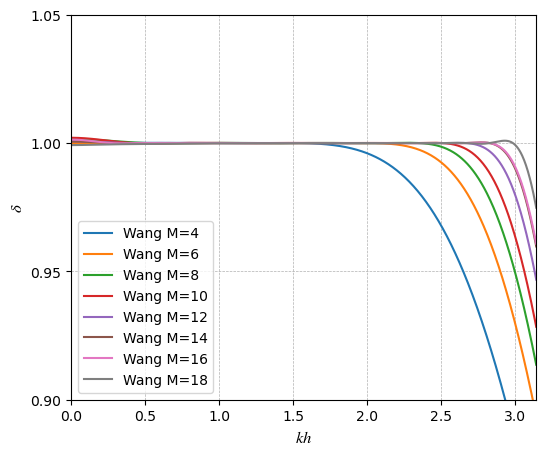

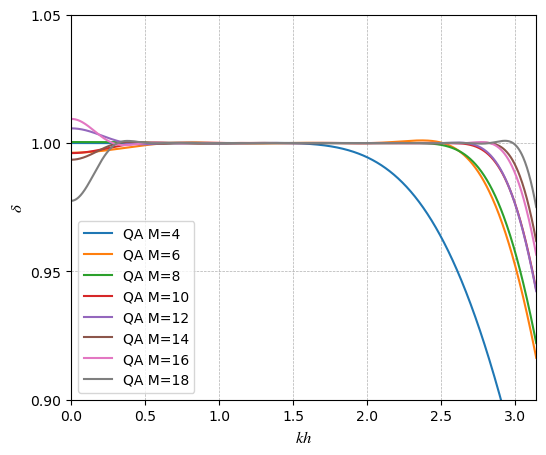

In [6]:
result_dict = {k: v for k, v in wang_a0_dict.items() if "Wang" in k}
fig, ax = show_disp_curve(result_dict)
result_dict = {k: v for k, v in qa_a0_dict.items() if "QA" in k}
fig, ax = show_disp_curve(result_dict)

## Time Consuming with Problem Scale

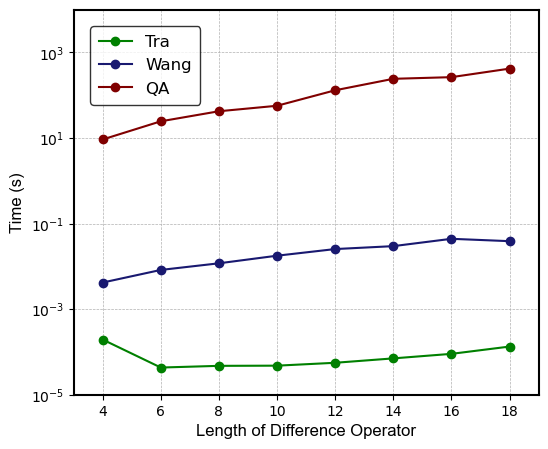

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))
ax.plot(M_set, tra_time, "o-", color="green", label = "Tra")
ax.plot(M_set, wang_time, "o-", color="midnightblue", label="Wang")
ax.plot(M_set, qa_time, "o-", color="maroon", label="QA")
ax.set_yscale("log")
ax.set_ylabel("Time (s)", fontfamily="Arial", fontsize=12)
ax.set_xlabel("Length of Difference Operator", fontfamily="Arial", fontsize=12)
ax.set_ylim([1e-5, 1e4])
ax.set_xlim([3, 19])

# ax.set_xticks([4, 1, 1.5, 2, 2.5, 3])
# ax[0].set_yticks([0.9, 0.95, 1.0, 1.05])
ax.spines["left"].set_linewidth(1.5)
ax.spines["top"].set_linewidth(1.5)
ax.spines["right"].set_linewidth(1.5)
ax.spines["bottom"].set_linewidth(1.5)

ax.grid(
    visible=True, axis="both", which="major", linestyle="--", linewidth=0.5
)
ax.legend(
    title="",
    fontsize=12,
    loc="upper left",
    borderpad=0.5,
    borderaxespad=1.0,
    labelspacing=0.5,
    edgecolor="black",
    handlelength=2.0,
)
fig.savefig("Total_time_consum.png", dpi=600)
fig.savefig("Total_time_consum.pdf", dpi=600)

In [37]:
np.mean(np.array(wang_time) / np.array(tra_time))

311.2843972579493

In [29]:
np.array(qa_time) / np.array(wang_time)

array([ 2212.11465153,  2982.22894128,  3584.59135021,  3197.70226492,
        5151.17289205,  8156.92032326,  6008.56134923, 10806.01263111])

In [30]:
# maximum solving time
qa_time[-1]/60

6.968219604166612

## Counting the number of iterations

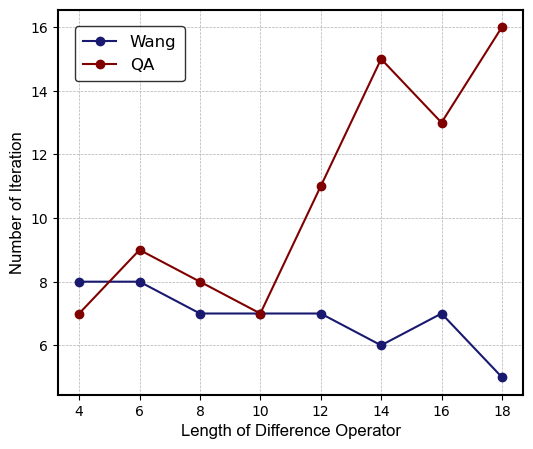

In [ ]:
wang_result_list = [v for k, v in wang_a0_dict.items() if "Iter" in k]
qa_result_list = [v for k, v in qa_a0_dict.items() if "Iter" in k]

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(M_set, wang_result_list, "o-", color="midnightblue", label="Wang")
ax.plot(M_set, qa_result_list, "o-", color="maroon", label="QA")

ax.spines["left"].set_linewidth(1.5)
ax.spines["top"].set_linewidth(1.5)
ax.spines["right"].set_linewidth(1.5)
ax.spines["bottom"].set_linewidth(1.5)
# ax.set_ylim([0.9, 1.05])
# ax.set_xlim([0, 3.142])
# ax.set_ylabel(
#     "$\delta$",
#     fontfamily="Arial",
#     fontsize=12,
#     math_fontfamily="stix",
# )
ax.set_xlabel("Length of Difference Operator", fontfamily="Arial", fontsize=12)
ax.set_ylabel("Number of Iteration", fontfamily="Arial", fontsize=12)

# ax.set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
# ax.set_yticks([0.9, 0.95, 1.0, 1.05])

ax.grid(visible=True, axis="both", which="major", linestyle="--", linewidth=0.5)

ax.legend(
    title="",
    fontsize=12,
    loc="upper left",
    borderpad=0.5,
    borderaxespad=1.0,
    labelspacing=0.5,
    edgecolor="black",
    handlelength=2.0,
)


## Time consuming of each iteration

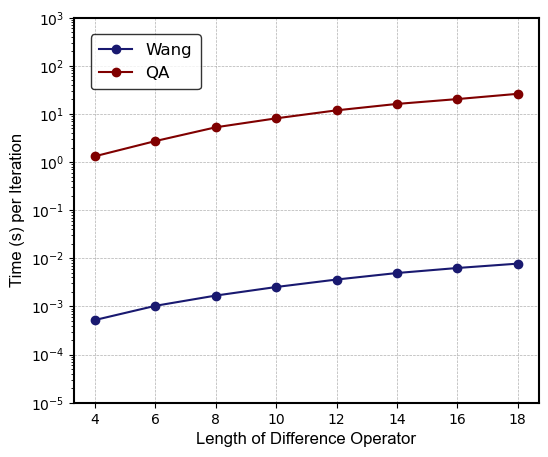

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
# ax.plot(M_set, tra_time, "o-", color="green", label="Tra")
ax.plot(M_set, np.array(wang_time) / np.array(wang_result_list), "o-", color="midnightblue", label="Wang")
ax.plot(M_set, np.array(qa_time) / np.array(qa_result_list), "o-", color="maroon", label="QA")
ax.set_yscale("log")
ax.set_ylabel("Time (s) per Iteration", fontfamily="Arial", fontsize=12)
ax.set_xlabel("Length of Difference Operator", fontfamily="Arial", fontsize=12)
ax.set_ylim([1e-5, 1e3])
# ax.set_xlim([3, 15])

# ax.set_xticks([4, 1, 1.5, 2, 2.5, 3])
# ax[0].set_yticks([0.9, 0.95, 1.0, 1.05])
ax.spines["left"].set_linewidth(1.5)
ax.spines["top"].set_linewidth(1.5)
ax.spines["right"].set_linewidth(1.5)
ax.spines["bottom"].set_linewidth(1.5)

ax.grid(visible=True, axis="both", which="major", linestyle="--", linewidth=0.5)
ax.legend(
    title="",
    fontsize=12,
    loc="upper left",
    borderpad=0.5,
    borderaxespad=1.0,
    labelspacing=0.5,
    edgecolor="black",
    handlelength=2.0,
)


In [41]:
(
    np.array(qa_time) / np.array(qa_result_list)
)/(np.array(wang_time) / np.array(wang_result_list) )

array([2528.13103033, 2650.87017003, 3136.51743143, 3197.70226492,
       3278.01911312, 3262.7681293 , 3235.37918804, 3376.87894722])